## 1D Heat Equation with FVM

In [101]:
using LinearAlgebra, LinearSolve, Plots, LaTeXStrings

## Steady State

### Without source term

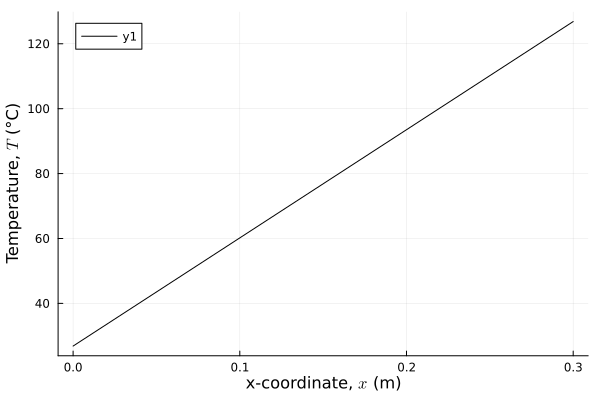

In [102]:
# Problem specs
T_loBC = 300.
T_upBC = 400.
k = 50.
L = 0.3

# Discretization
Nx = 100
dx = L/(Nx+1)
x_vec = range(0, L, Nx+2)

# Setting coefficients
aE = fill(k / dx, Nx)
aW = fill(k / dx, Nx)
aP = aE + aW
A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
b = zeros(Nx)
b[1] = (k/dx) * T_loBC
b[end] = (k/dx) * T_upBC

# Solving (LSEs)
prob = LinearProblem(A, b)
sol = solve(prob)

# Plotting
Tx_vec = sol.u
append!(sol.u, T_upBC)
insert!(Tx_vec, 1, T_loBC)
plot(x_vec, Tx_vec.-273.15, xlabel=L"x-coordinate, $x$ (m)", ylabel=L"Temperature, $T$ (°C)", c="black")

## With source term

In [103]:
# Problem specs
S(T) = - T^2
dT = 0.001

# Iterative solution

## Initializing
i=0
imax = 100
atol = 1e-6
T0 = ones(Nx) * ((T_loBC+T_upBC) / 2.0);      # Initial guess

while i<imax

    ## Setting coefficients
    dSdT = @. (S(T0+dT) - S(T0)) / dT 
    S_P = dSdT
    S_C = @. S(T0) - dSdT*T0
    aE = fill(k / dx, Nx)
    aW = fill(k / dx, Nx)
    aP = aE + aW - S_P*dx
    A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
    b = S_C*dx
    b[1] = (k/dx) * T_loBC
    b[end] = (k/dx) * T_upBC
    
    ## Solving (LSEs)
    prob = LinearProblem(A, b)
    sol = solve(prob)

    ## Checking convergence criteria
    if norm(sol.u-T0, 2) < atol
        println(i)
        println("Converged!")
        break
    end

    ## Updating loop variables
    T0 = copy(sol.u)
    i += 1
end

3
Converged!


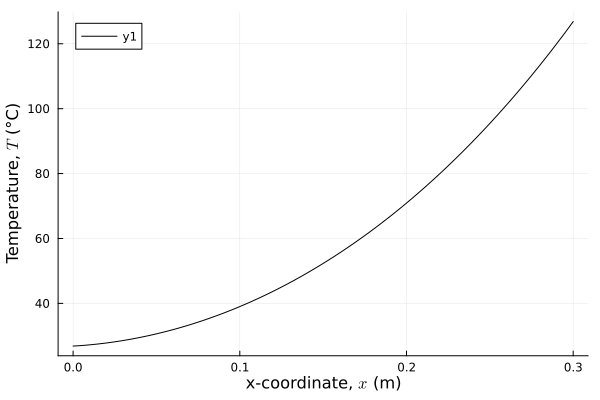

In [104]:
# Plotting
Tx_vec = sol.u
append!(sol.u, T_upBC)
insert!(Tx_vec, 1, T_loBC)
plot(x_vec, Tx_vec.-273.15, xlabel=L"x-coordinate, $x$ (m)", ylabel=L"Temperature, $T$ (°C)", c="black")

## Transient Case

In [109]:
# Numeric solution

function solve_PDE(Txt_mat, T0, t_vec, pars, memory)

    t = t_vec[1]; tf = t_vec[end]
    T = T0

    k, dt, dx, rho, cp, T_loBC, T_upBC = pars
    aE, aW, aP0, aP, A, b = memory
    Txt_mat[2:end-1,1] = copy(T)
    i = 2

    while t<tf

        ## Setting coefficients
        T0 = T
        S_P = 0.; S_C = 0.
        aE[:] .= k / dx
        aW[:] .= k / dx
        aP0[:] .= (rho * cp * dx) / dt
        aP[:] = @. aE + aW + aP0 - S_P*dx
        A[:,:] = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
        b[:] = @. S_C*dx + aP0*T0
        b[1] = b[1] .+ (k/dx) * T_loBC
        b[end] = b[end] .+ (k/dx) * T_upBC

        ## Solving (LSEs)
        prob = LinearProblem(A, b)
        sol = solve(prob)
        T = sol.u

        ## Saving solution
        if t > t_vec[i]
            Txt_mat[2:end-1, i] = copy(T)
            i += 1
        end

        t += dt

    end

    Txt_mat[2:end-1, end] = copy(T)

    return nothing
end

solve_PDE (generic function with 1 method)

In [110]:
# Problem specs
rho = 2000
cp = 420
alpha = k / (rho * cp)       
T_loBC = 0.
T_upBC = 0.

# Initial condition
dt = (dx^2 / (2.0*alpha))
t = 0.
tf = (L^2/alpha) / 12
t_vec = range(0, tf, 6)
T0 = T0x_vec[2:end-1]

# Memory allocation
Txt_mat = zeros((Nx+2, length(t_vec)))
aE = zeros(Nx); aW = zeros(Nx); aP0 = zeros(Nx); aP = zeros(Nx)
A = zeros((Nx, Nx)); b = zeros(Nx)
memory = (aE, aW, aP0, aP, A, b)
pars = (k, dt, dx, rho, cp, T_loBC, T_upBC);

In [111]:
# Solve
sol = solve_PDE(Txt_mat, T0, t_vec, pars, memory);

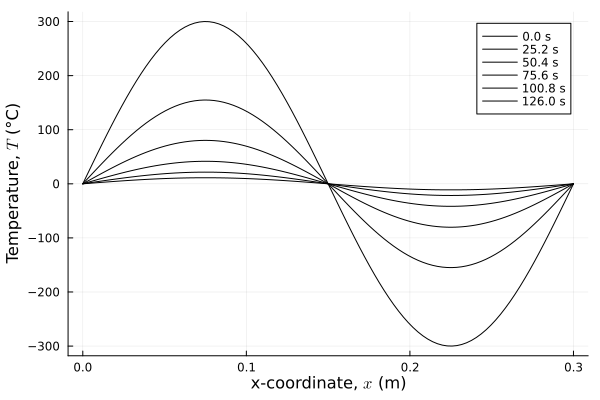

In [112]:
# Plotting
plt = plot()
for (i_t,t) in enumerate(t_vec)
    plot!(plt, x_vec, Txt_mat[1:end, i_t], xlabel=L"x-coordinate, $x$ (m)", ylabel=L"Temperature, $T$ (°C)", c="black", label=string(t)*" s")
end
plt